## Android Tap and Sensor Fusion

### Import Libraries

In [29]:
import pandas as pd
import numpy as np
from collections import OrderedDict as od
from numpy import mean, var
from scipy.stats import skew, kurtosis
import json
import matplotlib.pyplot as plt
import glob
import os

##### Sensor Data Parser

In [4]:
ls ../Data/SensorInfo/

201711051937  201711061526  201711091951  201711092033


In [66]:
def parseSensorData(filename):
    x=pd.read_csv(filename)
    x.columns=x.columns.map(lambda x:str(x).strip())
    sensorNameDict=dict(zip(set(x.sensorName),[str(sensor).strip().partition(' ')[2] for sensor in (set(x.sensorName))]))
    x['sensorName']=x['sensorName'].replace(sensorNameDict)
    data_Accelerometer=x.loc[x.sensorName=="Accelerometer"].reset_index().drop(['index','sensorName'],axis=1)
    data_Gyroscope=x.loc[x.sensorName=="Gyroscope"].reset_index().drop(['index','sensorName'],axis=1)
    data_Magnetometer=x.loc[x.sensorName=="Magnetometer"].reset_index().drop(['index','sensorName'],axis=1)
    acc=data_Accelerometer[['timestamp','lastAccelerometerValues[0]','lastAccelerometerValues[1]','lastAccelerometerValues[2]']].groupby('timestamp').mean()
    gyr=data_Gyroscope[['timestamp','lastGyroscopeValues[0]','lastGyroscopeValues[1]','lastGyroscopeValues[2]']].groupby('timestamp').mean()
    mag=data_Magnetometer[['timestamp','lastMagnetometerValues[0]','lastMagnetometerValues[1]','lastMagnetometerValues[2]']].groupby('timestamp').mean()
    return acc,gyr,mag

##### Tap Data Parser

In [70]:
ls ../Data/TapInfo/

ml16-141402-201711091951-export.json  ml16-141402-201711092033-export.json


In [82]:
def parseTapData(filename):
    tapInfo=pd.read_json(filename)
    cols=['eventTime', 'pointerCount', 'source', 'buttonState', 'actionButton', 'id0', 'historySize', 'toolType0', 'flags', 'deviceId', 'downTime', 'action', 'y0', 'x0', 'metaState', 'edgeFlags']
    df=pd.DataFrame(columns=cols)
    for btnID, btn in tapInfo.btnID.iteritems():
        sample=ast.literal_eval(str(btn).replace('u\'','\''))
        for timestamp in sample.keys():
            event=ast.literal_eval(str(sample[timestamp]))
            if type(event) is dict:
                idx = event.keys()[0]
                row=str(event[idx]) 
            else:
                idx=0
                row=str(event[0])
            t=row.replace('MotionEvent ','').replace('[','').replace(']','').replace('=','\':\'').replace(', ','\', \'').replace('\'{ ','{\'').replace(' }\'','\'}')
            dt=ast.literal_eval(t)
            dx=pd.DataFrame.from_records([dt],index=[0])
            if '2' in dx.columns:
                dx=pd.DataFrame.from_records([dx['2'][0]],index=[0]) 
            dx['action']=dx['action'][0][7:]
            dx['id0']=idx
            dx['actionButton']=int(btnID)
            dx['buttonState']=long(timestamp)
            dx['downTime']=long(dx['downTime'])
            dx['eventTime']=long(dx['eventTime'])
            df=pd.concat([df,dx],axis=0)
    df=df.sort('eventTime').reset_index().drop(['index','metaState','deviceId','edgeFlags','flags','historySize','pointerCount','source','toolType0','id0','x0','y0'],axis=1)
    df=df[df['action']=='UP']
    return df

### Load all data

In [87]:
accData=od()
gyrData=od()
magData=od()
tapData=od()

In [88]:
for filename in glob.glob('../Data/SensorInfo/20171109*'):
    key=filename.split('/')[-1]
    accData[key],gyrData[key],magData[key]=readSensorRecording(filename)

In [89]:
for filename in glob.glob('../Data/TapInfo/ml16-141402-20171109*'):
    key=filename.split('ml16-141402-')[-1].split('-')[0]
    print(key)
    tapData[key]=parseTapData(filename)

201711091951


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


201711092033


### Data Integration & Feature Extraction

In [97]:
data=od()

In [261]:
def fusion(acc, gyr, mag, tap):
    df=pd.DataFrame()
    for idx,row in tap.iterrows():
        a=acc.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        g=gyr.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        m=mag.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        d=pd.concat([
           pd.DataFrame([row['actionButton']],columns=['target']).T,
            a.apply(mean).rename(lambda x:x+'_mean').T,
            a.apply(var).rename(lambda x:x+'_var'),
            a.apply(skew).rename(lambda x:x+'_skew'),
            a.apply(kurtosis).rename(lambda x:x+'_kurtosis'),
            g.apply(mean).rename(lambda x:x+'_mean'),
            g.apply(var).rename(lambda x:x+'_var'),
            g.apply(skew).rename(lambda x:x+'_skew'),
            g.apply(kurtosis).rename(lambda x:x+'_kurtosis'),
            m.apply(mean).rename(lambda x:x+'_mean'),
            m.apply(var).rename(lambda x:x+'_var'),
            m.apply(skew).rename(lambda x:x+'_skew'),
            m.apply(kurtosis).rename(lambda x:x+'_kurtosis')]
            ,axis=0).T
        df=df.append([d],ignore_index=True)
    return df

In [262]:
for key in tapData.keys():
        data[key]=fusion(accData[key], gyrData[key], magData[key], tapData[key])

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483
485
487
489
491
493
495
497
499
501
503
505
507
510
512
514
516
518
520
522
524
526
528
53

1050
1054
1056
1058
1060
1062
1064
1066
1068
1070
1072
1074
1077
1080
1082
1084
1086
1088
1090
1092
1094
1096
1098
1100
1102
1104
1106
1108
1110
1112
1115
1121
1124
1126
1129
1131
1133
1135
1137
1139
1141
1143
1146
1148
1151
1153
1161
1166
1168
1170
1172
1176
1179
1181
1186
1188
1190
1192
1194
1196
1202
1205
1207
1212
1214
1216
1218
1221
1223
1225
1227
1229
1233
1235
1237
1239
1241
1243
1245
1247
1249
1251
1256
1258
1260
1262
1264
1266
1276
1280
1282
1284
1286
1288
1290
1292
1294
1296
1298
1300
1302
1304
1306
1308
1310
1312
1314
1316
1318
1320
1322
1324
1326
1328
1330
1332
1334
1336
1338
1340
1342
1344
1346
1348
1350
1352
1354
1356
1358
1360
1362
1364
1366
1368
1370
1372
1374
1377
1379
1381
1383
1385
1387
1389
1391
1393
1395
1397
1399
1401
1403
1405
1407
1409
1411
1413
1415
1417
1419
1421
1423
1425
1427
1429
1434
1436
1438
1440
1442
1444
1446
1448
1450
1452
1454
1460
1462
1464
1466
1468
1470
1472
1474
1476
1478
1480
1482
1484
1486
1488
1490
1492
1494
1496
1498
1500
1502
1504
1506
1509


In [268]:
for key in data.keys():
    data[key].to_csv(str(data)+'_features.csv')

IOError: [Errno 63] File name too long: "OrderedDict([('201711091951',       target  lastAccelerometerValues[0]_mean  \\\n0        0.0                         0.197777   \n1        0.0                         0.160095   \n2        0.0                         0.257395   \n3        0.0                         0.162089   \n4        0.0                         0.315231   \n5        0.0                         0.220708   \n6        0.0                         0.233665   \n7        0.0                         0.290502   \n8        0.0                         0.259991   \n9        0.0                         0.299672   \n10       1.0                         0.148422   \n11       1.0                         0.366177   \n12       1.0                         0.292591   \n13       1.0                         0.282846   \n14       1.0                         0.400570   \n15       1.0                         0.153707   \n16       1.0                         0.210640   \n17       1.0                         0.226690   \n18       1.0                         0.335489   \n19       1.0                         0.300968   \n20       2.0                         0.244438   \n21       2.0                         0.143944   \n22       2.0                         0.102066   \n23       2.0                         0.176442   \n24       2.0                         0.056402   \n25       2.0                         0.256699   \n26       2.0                         0.292595   \n27       2.0                         0.338058   \n28       2.0                         0.217921   \n29       2.0                         0.355504   \n...      ...                              ...   \n1410   141.0                         0.982030   \n1411   141.0                         1.474945   \n1412   141.0                         1.257202   \n1413   141.0                         1.360092   \n1414   141.0                         1.452812   \n1415   141.0                         1.498879   \n1416   141.0                         1.380432   \n1417   141.0                         1.348923   \n1418   141.0                         1.324204   \n1419   141.0                         1.153503   \n1420   142.0                         1.544739   \n1421   142.0                         1.309845   \n1422   142.0                         1.230881   \n1423   142.0                         1.167867   \n1424   142.0                         1.448631   \n1425   142.0                         1.296684   \n1426   142.0                         1.351112   \n1427   142.0                         1.368469   \n1428   142.0                         1.291893   \n1429   142.0                         1.365479   \n1430   143.0                         1.366074   \n1431   143.0                         1.382828   \n1432   143.0                         1.495285   \n1433   143.0                         1.433670   \n1434   143.0                         1.412140   \n1435   143.0                         1.413925   \n1436   143.0                         1.314629   \n1437   143.0                         1.364878   \n1438   143.0                         1.360695   \n1439   143.0                         1.206151   \n\n      lastAccelerometerValues[1]_mean  lastAccelerometerValues[2]_mean  \\\n0                            9.575432                         2.174862   \n1                            9.611023                         1.728897   \n2                            9.581512                         2.060308   \n3                            9.587891                         2.055522   \n4                            9.566355                         1.884038   \n5                            9.542826                         1.867284   \n6                            9.568550                         2.023216   \n7                            9.555186                         1.940664   \n8                            9.593975                         2.016640   \n9                            9.613418                         1.919530   \n10                           9.619396                         2.139267   \n11                           9.563767                         2.070477   \n12                           9.569149                         2.045944   \n13                           9.549530                         2.018912   \n14                           9.515011                         1.982239   \n15                           9.626979                         1.822622   \n16                           9.637047                         1.888321   \n17                           9.624980                         1.783534   \n18                           9.572021                         1.898071   \n19                           9.545216                         1.936478   \n20                           9.599053                         1.895203   \n21                           9.683403                         1.905373   \n22                           9.697166                         1.680443   \n23                           9.651301                         1.856517   \n24                           9.678421                         1.725311   \n25                           9.650204                         2.032787   \n26                           9.597862                         1.932293   \n27                           9.592178                         1.902676   \n28                           9.593872                         1.968582   \n29                           9.580714                         1.816238   \n...                               ...                              ...   \n1410                         9.665659                         0.615433   \n1411                         9.683403                         1.514153   \n1412                         9.571548                         1.676254   \n1413                         9.613411                         1.173164   \n1414                         9.542222                         1.202476   \n1415                         9.544624                         1.113342   \n1416                         9.633156                         1.363991   \n1417                         9.615011                         1.104370   \n1418                         9.675629                         1.811447   \n1419                         9.650904                         0.942454   \n1420                         9.553197                         1.220423   \n1421                         9.601456                         1.639160   \n1422                         9.627767                         1.009054   \n1423                         9.709523                         0.948441   \n1424                         9.499756                         1.081047   \n1425                         9.747414                         1.774361   \n1426                         9.649902                         1.452530   \n1427                         9.606834                         1.591911   \n1428                         9.663063                         1.432785   \n1429                         9.575126                         1.733681   \n1430                         9.584107                         1.192909   \n1431                         9.528473                         1.154617   \n1432                         9.559570                         1.316132   \n1433                         9.519500                         1.202476   \n1434                         9.512321                         1.250336   \n1435                         9.609230                         0.975761   \n1436                         9.598457                         1.167778   \n1437                         9.592677                         0.892609   \n1438                         9.621796                         1.137871   \n1439                         9.636943                         1.008662   \n\n      lastAccelerometerValues[0]_var  lastAccelerometerValues[1]_var  \\\n0                           0.046755                        0.007773   \n1                           0.000000                        0.000000   \n2                           0.003506                        0.004467   \n3                           0.011951                        0.000096   \n4                           0.000166                        0.004906   \n5                           0.008167                        0.018534   \n6                           0.000344                        0.001512   \n7                           0.005901                        0.004443   \n8                           0.013834                        0.008655   \n9                           0.001111                        0.004937   \n10                          0.049820                        0.015290   \n11                          0.011023                        0.005569   \n12                          0.011777                        0.005218   \n13                          0.030169                        0.013660   \n14                          0.023643                        0.009417   \n15                          0.006600                        0.002300   \n16                          0.037090                        0.007332   \n17                          0.010407                        0.000296   \n18                          0.008125                        0.003767   \n19                          0.008158                        0.005322   \n20                          0.000158                        0.002067   \n21                          0.000003                        0.002586   \n22                          0.002122                        0.000006   \n23                          0.002835                        0.005793   \n24                          0.018385                        0.002722   \n25                          0.012271                        0.002901   \n26                          0.007803                        0.003418   \n27                          0.005307                        0.003465   \n28                          0.009581                        0.002116   \n29                          0.009093                        0.003583   \n...                              ...                             ...   \n1410                        0.513977                        0.025065   \n1411                        0.000322                        0.000544   \n1412                        0.000000                        0.000000   \n1413                        0.005682                        0.003162   \n1414                        0.000158                        0.002233   \n1415                        0.010341                        0.002348   \n1416                        0.008709                        0.000060   \n1417                        0.038881                        0.013429   \n1418                        0.000000                        0.000000   \n1419                        0.254306                        0.026024   \n1420                        0.027887                        0.011435   \n1421                        0.000000                        0.000000   \n1422                        0.080722                        0.025998   \n1423                        0.182666                        0.021720   \n1424                        0.072462                        0.006235   \n1425                        0.008934                        0.000322   \n1426                        0.000390                        0.000009   \n1427                        0.011595                        0.001704   \n1428                        0.000001                        0.000103   \n1429                        0.005414                        0.002067   \n1430                        0.023451                        0.004569   \n1431                        0.000000                        0.000000   \n1432                        0.000000                        0.000000   \n1433                        0.000390                        0.001512   \n1434                        0.004251                        0.003230   \n1435                        0.004983                        0.000261   \n1436                        0.004815                        0.000129   \n1437                        0.066536                        0.010166   \n1438                        0.011466                        0.000894   \n1439                        0.136589                        0.028786   \n\n      lastAccelerometerValues[2]_var  lastAccelerometerValues[0]_skew  \\\n0                           0.386740                     3.355454e-01   \n1                           0.000000                     0.000000e+00   \n2                           0.164733                     5.048864e-01   \n3                           0.118089                     4.781836e-01   \n4                           0.179591                     3.557069e-01   \n5                           0.737463                    -6.978246e-01   \n6                           0.199153                    -2.256963e-15   \n7                           0.285493                     4.555691e-01   \n8                           0.425735                     5.049698e-01   \n9                           0.211062                     6.962319e-01   \n10                          0.176414                     1.483057e-01   \n11                          0.367616                    -3.153413e-02   \n12                          0.402748                     1.275596e-01   \n13                          0.706999                     3.910072e-01   \n14                          0.756363                    -1.963080e-01   \n15                          0.212729                    -6.180445e-01   \n16                          0.434645                     1.430333e-02   \n17                          0.314054                     6.420356e-01   \n18                          0.123210                     1.019018e+00   \n19                          0.389993                    -3.636674e-01   \n20                          0.051130                     0.000000e+00   \n21                          0.102429                     0.000000e+00   \n22                          0.027457                     4.852202e-16   \n23                          0.080683                     6.472449e-01   \n24                          0.304096                    -6.701350e-01   \n25                          0.106867                    -5.160026e-02   \n26                          0.253445                    -4.137079e-01   \n27                          0.081038                     7.851297e-03   \n28                          0.232192                     7.051270e-01   \n29                          0.184079                     7.040955e-01   \n...                              ...                              ...   \n1410                        2.718415                    -3.641591e-01   \n1411                        0.150728                    -1.854418e-14   \n1412                        0.000000                     0.000000e+00   \n1413                        0.432218                     4.430030e-15   \n1414                        0.667728                     2.646929e-14   \n1415                        1.035403                     3.196017e-15   \n1416                        0.270857                     0.000000e+00   \n1417                        0.216177                    -6.958870e-01   \n1418                        0.000000                     0.000000e+00   \n1419                        0.899260                    -6.990446e-01   \n1420                        0.286427                    -2.695517e-01   \n1421                        0.000000                     0.000000e+00   \n1422                        0.304136                    -6.913288e-01   \n1423                        0.403590                    -6.713327e-01   \n1424                        2.622284                     0.000000e+00   \n1425                        0.054429                     0.000000e+00   \n1426                        0.491535                    -1.696528e-14   \n1427                        0.003797                     0.000000e+00   \n1428                        0.398292                     2.780913e-13   \n1429                        0.000757                     0.000000e+00   \n1430                        0.352150                     0.000000e+00   \n1431                        0.000000                     0.000000e+00   \n1432                        0.000000                     0.000000e+00   \n1433                        0.000280                     0.000000e+00   \n1434                        0.064942                    -5.085046e-15   \n1435                        0.265279                     4.701140e-15   \n1436                        0.032637                     0.000000e+00   \n1437                        0.437118                     4.174198e-02   \n1438                        0.011339                     3.179108e-15   \n1439                        0.527728                    -6.995064e-01   \n\n      lastAccelerometerValues[1]_skew  lastAccelerometerValues[2]_skew  \\\n0                       -6.101483e-01                    -6.520453e-01   \n1                        0.000000e+00                     0.000000e+00   \n2                       -2.291275e-01                    -5.686055e-01   \n3                        5.829555e-01                    -7.039966e-01   \n4                       -6.972258e-01                     4.483047e-01   \n5                       -6.321107e-01                    -3.737141e-01   \n6                        0.000000e+00                     0.000000e+00   \n7                       -4.437871e-01                    -3.749870e-01   \n8                       -2.642056e-02                    -1.370394e-01   \n9                       -7.032658e-01                     6.793554e-01   \n10                      -2.381937e-03                    -1.318315e-02   \n11                       9.751614e-02                    -5.168017e-01   \n12                      -2.642420e-01                    -6.384364e-01   \n13                      -2.342625e-01                    -3.172639e-01   \n14                       1.749674e-01                    -6.173006e-01   \n15                       4.905552e-01                    -2.210390e-01   \n16                       1.958264e-03                    -6.488619e-01   \n17                       7.045032e-01                    -4.381415e-01   \n18                      -2.642880e-01                     6.999692e-02   \n19                       7.994728e-01                    -5.117668e-01   \n20                       0.000000e+00                    -1.500422e-15   \n21                       0.000000e+00                    -1.058340e-15   \n22                       0.000000e+00                    -2.001705e-15   \n23                      -5.499055e-01                     3.829408e-01   \n24                       7.068234e-01                    -9.753487e-03   \n25                       8.048837e-02                    -3.727079e-01   \n26                      -1.310693e-01                    -5.017630e-01   \n27                      -3.454618e-02                    -4.828604e-01   \n28                      -1.292128e-01                    -4.612815e-01   \n29                       1.974888e-01                    -2.853820e-01   \n...                               ...                              ...   \n1410                     5.492054e-01                     6.387552e-01   \n1411                     0.000000e+00                     0.000000e+00   \n1412                     0.000000e+00                     0.000000e+00   \n1413                     4.739881e-14                    -2.930339e-16   \n1414                    -5.637676e-14                     4.069497e-16   \n1415                     0.000000e+00                     0.000000e+00   \n1416                    -3.427063e-13                     0.000000e+00   \n1417                     6.926530e-01                    -3.106286e-01   \n1418                     0.000000e+00                     0.000000e+00   \n1419                     7.066420e-01                     7.037574e-01   \n1420                     7.038528e-01                    -6.709977e-01   \n1421                     0.000000e+00                     0.000000e+00   \n1422                     3.228880e-01                    -3.434026e-01   \n1423                     6.516105e-01                     5.625129e-01   \n1424                    -3.369103e-14                     0.000000e+00   \n1425                     1.484567e-13                     1.434430e-15   \n1426                     0.000000e+00                     0.000000e+00   \n1427                     0.000000e+00                    -5.386209e-15   \n1428                     0.000000e+00                     0.000000e+00   \n1429                     5.855416e-14                     1.203046e-14   \n1430                    -3.940252e-14                    -4.648657e-16   \n1431                     0.000000e+00                     0.000000e+00   \n1432                     0.000000e+00                     0.000000e+00   \n1433                     6.854569e-14                     0.000000e+00   \n1434                     4.681038e-14                    -1.467475e-15   \n1435                    -1.648602e-13                    -3.047097e-16   \n1436                     2.344925e-13                     0.000000e+00   \n1437                     3.686189e-01                    -6.787613e-01   \n1438                    -8.910130e-14                     3.053113e-15   \n1439                     6.071058e-01                     6.006603e-01   \n\n                     ...                  lastMagnetometerValues[2]_mean  \\\n0                    ...                                       15.041097   \n1                    ...                                             NaN   \n2                    ...                                       15.727743   \n3                    ...                                       15.407308   \n4                    ...                                       15.929158   \n5                    ...                                       15.507507   \n6                    ...                                       15.849304   \n7                    ...                                       15.408834   \n8                    ...                                       15.249634   \n9                    ...                                       15.486145   \n10                   ...                                       15.081787   \n11                   ...                                       16.384888   \n12                   ...                                       15.837478   \n13                   ...                                       15.473938   \n14                   ...                                       15.806579   \n15                   ...                                       16.076279   \n16                   ...                                       15.773392   \n17                   ...                                       15.503693   \n18                   ...                                       15.624237   \n19                   ...                                       15.464783   \n20                   ...                                       15.161641   \n21                   ...                                       15.986633   \n22                   ...                                       15.923309   \n23                   ...                                       15.443420   \n24                   ...                                       15.470887   \n25                   ...                                       16.130066   \n26                   ...                                       15.723673   \n27                   ...                                       15.770976   \n28                   ...                                       15.870667   \n29                   ...                                       16.090902   \n...                  ...                                             ...   \n1410                 ...                                       18.718465   \n1411                 ...                                       18.554179   \n1412                 ...                                       18.197632   \n1413                 ...                                       18.717957   \n1414                 ...                                       18.855286   \n1415                 ...                                       18.432617   \n1416                 ...                                       18.495942   \n1417                 ...                                       18.715922   \n1418                 ...                                       18.193054   \n1419                 ...                                       18.599447   \n1420                 ...                                       18.638103   \n1421                 ...                                       18.916320   \n1422                 ...                                       19.119771   \n1423                 ...                                       18.920898   \n1424                 ...                                       18.556214   \n1425                 ...                                       18.188477   \n1426                 ...                                       18.551636   \n1427                 ...                                       18.676758   \n1428                 ...                                       18.434143   \n1429                 ...                                       18.556213   \n1430                 ...                                       18.313598   \n1431                 ...                                       18.492890   \n1432                 ...                                       18.678284   \n1433                 ...                                       18.315125   \n1434                 ...                                       18.794759   \n1435                 ...                                       18.972778   \n1436                 ...                                       18.612671   \n1437                 ...                                       19.043731   \n1438                 ...                                       18.735504   \n1439                 ...                                       18.837992   \n\n      lastMagnetometerValues[0]_var  lastMagnetometerValues[1]_var  \\\n0                      1.887532e-02                       0.004782   \n1                               NaN                            NaN   \n2                      2.583851e-02                       0.024502   \n3                      2.934028e-02                       0.049403   \n4                      1.734485e-02                       0.160074   \n5                      1.831795e-03                       0.006375   \n6                      6.259005e-03                       0.001742   \n7                      2.543183e-02                       0.000035   \n8                      4.034852e-02                       0.023787   \n9                      5.263525e-03                       0.136795   \n10                     1.939829e-02                       0.050042   \n11                     2.340763e-02                       0.016367   \n12                     7.329509e-03                       0.032141   \n13                     4.410249e-03                       0.017845   \n14                     5.020387e-03                       0.018492   \n15                     2.164670e-02                       0.006231   \n16                     4.999312e-03                       0.014417   \n17                     2.437198e-02                       0.006449   \n18                     1.502573e-02                       0.086625   \n19                     3.310852e-03                       0.037056   \n20                     2.664565e-02                       0.040730   \n21                     4.714820e-05                       0.021013   \n22                     4.714827e-05                       0.035225   \n23                     6.562720e-03                       0.007669   \n24                     1.438355e-02                       0.001619   \n25                     1.467195e-02                       0.049403   \n26                     2.144112e-03                       0.024612   \n27                     2.069609e-06                       0.007327   \n28                     1.179404e-02                       0.024148   \n29                     8.414499e-03                       0.015774   \n...                             ...                            ...   \n1410                   6.659471e-03                       0.012966   \n1411                   1.513451e-02                       0.013319   \n1412                   0.000000e+00                       0.000000   \n1413                   1.304937e-02                       0.096114   \n1414                   2.165906e-03                       0.002238   \n1415                   2.165906e-03                       0.008243   \n1416                   1.891167e-03                       0.051345   \n1417                   5.174157e-07                       0.006844   \n1418                   0.000000e+00                       0.000000   \n1419                   1.466885e-02                       0.035847   \n1420                   6.786754e-03                       0.030725   \n1421                   0.000000e+00                       0.000000   \n1422                   8.214262e-03                       0.005132   \n1423                   2.151876e-03                       0.059860   \n1424                   2.384178e-03                       0.000002   \n1425                   2.190703e-02                       0.009095   \n1426                   8.663626e-03                       0.032419   \n1427                   2.237503e-03                       0.007833   \n1428                   0.000000e+00                       0.007565   \n1429                   2.459272e-03                       0.000009   \n1430                   9.989013e-03                       0.009095   \n1431                   2.852174e-03                       0.052387   \n1432                   0.000000e+00                       0.000000   \n1433                   0.000000e+00                       0.000000   \n1434                   1.931461e-03                       0.013136   \n1435                   1.891167e-03                       0.019922   \n1436                   2.328371e-06                       0.017623   \n1437                   2.328066e-06                       0.000009   \n1438                   9.536733e-03                       0.001635   \n1439                   2.841827e-02                       0.018006   \n\n      lastMagnetometerValues[2]_var  lastMagnetometerValues[0]_skew  \\\n0                          0.043302                    7.071068e-01   \n1                               NaN                             NaN   \n2                          0.023119                   -3.795430e-02   \n3                          0.041224                   -5.488026e-01   \n4                          0.155992                    6.865885e-01   \n5                          0.040422                   -1.143135e+00   \n6                          0.079914                    9.643302e-03   \n7                          0.013017                    9.567969e-03   \n8                          0.064123                    1.988868e-01   \n9                          0.023264                   -1.872791e-01   \n10                         0.066784                    4.378667e-01   \n11                         0.398463                    1.884311e-02   \n12                         0.025125                   -5.503186e-01   \n13                         0.075913                    1.204327e-01   \n14                         0.070342                    3.374115e-01   \n15                         0.016265                    8.701353e-01   \n16                         0.024526                   -1.615468e-02   \n17                         0.185655                   -2.252824e-02   \n18                         0.077589                   -8.851947e-01   \n19                         0.077506                   -3.972205e-02   \n20                         0.021846                   -3.737554e-02   \n21                         0.178649                    0.000000e+00   \n22                         0.058492                    1.218254e-14   \n23                         0.039736                    5.645333e-02   \n24                         0.068747                   -8.316257e-01   \n25                         0.234307                    4.945888e-01   \n26                         0.062297                   -6.704282e-01   \n27                         0.012916                    7.071068e-01   \n28                         0.010449                    7.437977e-01   \n29                         0.062835                    7.057863e-01   \n...                             ...                             ...   \n1410                       0.080734                    9.348996e-03   \n1411                       0.066227                    3.783784e-01   \n1412                       0.000000                    0.000000e+00   \n1413                       0.012844                    4.318370e-01   \n1414                       0.032419                    0.000000e+00   \n1415                       0.000002                    0.000000e+00   \n1416                       0.033249                    0.000000e+00   \n1417                       0.090742                    7.071068e-01   \n1418                       0.000000                    0.000000e+00   \n1419                       0.003363                    4.611286e-01   \n1420                       0.091893                   -1.290103e-01   \n1421                       0.000000                    0.000000e+00   \n1422                       0.022938                   -7.071068e-01   \n1423                       0.203067                   -6.113732e-01   \n1424                       0.000002                    0.000000e+00   \n1425                       0.013448                    0.000000e+00   \n1426                       0.015276                    0.000000e+00   \n1427                       0.014901                    0.000000e+00   \n1428                       0.130778                    0.000000e+00   \n1429                       0.014901                    0.000000e+00   \n1430                       0.000009                    0.000000e+00   \n1431                       0.089901                    0.000000e+00   \n1432                       0.000000                    0.000000e+00   \n1433                       0.000000                    0.000000e+00   \n1434                       0.009689                    6.968918e-01   \n1435                       0.090359                    0.000000e+00   \n1436                       0.178649                    0.000000e+00   \n1437                       0.058492                    0.000000e+00   \n1438                       0.033808                    0.000000e+00   \n1439                       0.021731                   -5.280051e-01   \n\n      lastMagnetometerValues[1]_skew  lastMagnetometerValues[2]_skew  \\\n0                       3.308917e-02                    5.112854e-01   \n1                                NaN                             NaN   \n2                       4.683067e-01                    3.249254e-01   \n3                      -7.070069e-01                    4.969305e-01   \n4                       6.149196e-01                    1.931508e-02   \n5                      -1.144514e+00                    4.994072e-01   \n6                      -7.042704e-01                   -7.070450e-01   \n7                       5.672200e-01                    7.024618e-01   \n8                       6.079457e-01                    2.311605e-01   \n9                      -6.679906e-01                    3.981928e-01   \n10                      1.281110e-05                    3.188415e-01   \n11                      5.328058e-01                   -4.511882e-01   \n12                     -1.024235e+00                    1.988328e-01   \n13                      4.588506e-01                    8.289970e-01   \n14                      7.913529e-01                    1.112422e-01   \n15                     -5.138726e-01                    6.082882e-01   \n16                     -1.775136e-01                   -2.132229e-01   \n17                      1.123538e+00                   -1.106081e-01   \n18                      2.713843e-01                   -4.985169e-01   \n19                     -3.963545e-01                    3.326403e-01   \n20                     -6.165066e-01                   -3.381900e-01   \n21                      0.000000e+00                    0.000000e+00   \n22                      0.000000e+00                    0.000000e+00   \n23                     -6.940879e-01                    2.508279e-06   \n24                      1.092687e+00                   -3.475950e-01   \n25                     -7.070068e-01                   -6.701039e-01   \n26                     -4.822952e-01                    2.402075e-01   \n27                      7.071068e-01                    7.071068e-01   \n28                      5.089975e-01                   -1.152654e+00   \n29                      7.032739e-01                    2.276474e-01   \n...                              ...                             ...   \n1410                    4.491490e-01                   -7.068620e-01   \n1411                    3.781421e-01                    5.981760e-01   \n1412                    0.000000e+00                    0.000000e+00   \n1413                    5.295758e-01                   -7.047038e-01   \n1414                    0.000000e+00                    0.000000e+00   \n1415                   -1.174219e-13                    0.000000e+00   \n1416                    4.704185e-14                   -2.925700e-14   \n1417                   -7.063851e-01                   -3.790053e-01   \n1418                    0.000000e+00                    0.000000e+00   \n1419                   -2.866213e-01                    6.979385e-01   \n1420                    7.022481e-01                    3.790229e-01   \n1421                    0.000000e+00                    0.000000e+00   \n1422                    1.065031e-02                   -4.091358e-01   \n1423                    6.129252e-01                    3.864549e-01   \n1424                    0.000000e+00                    3.492152e-12   \n1425                   -1.118123e-13                    0.000000e+00   \n1426                    0.000000e+00                   -4.306836e-14   \n1427                    1.204340e-13                    0.000000e+00   \n1428                   -1.226027e-13                    1.467189e-14   \n1429                    0.000000e+00                    0.000000e+00   \n1430                    0.000000e+00                    1.746323e-12   \n1431                    0.000000e+00                    0.000000e+00   \n1432                    0.000000e+00                    0.000000e+00   \n1433                    0.000000e+00                    0.000000e+00   \n1434                    4.142089e-01                    3.098648e-02   \n1435                    7.549804e-14                    1.775484e-14   \n1436                    0.000000e+00                    0.000000e+00   \n1437                    0.000000e+00                    0.000000e+00   \n1438                   -2.635141e-13                    2.895319e-14   \n1439                   -7.053930e-01                    4.316543e-01   \n\n      lastMagnetometerValues[0]_kurtosis  lastMagnetometerValues[1]_kurtosis  \\\n0                              -1.500000                           -1.500000   \n1                                    NaN                                 NaN   \n2                              -1.500000                           -1.500000   \n3                              -1.500000                           -1.500000   \n4                              -1.500000                           -1.500000   \n5                              -0.676050                           -0.674906   \n6                              -1.500000                           -1.500000   \n7                              -1.500000                           -1.500000   \n8                              -1.500000                           -1.500000   \n9                              -1.500000                           -1.500000   \n10                             -1.149225                           -1.087428   \n11                             -1.602978                           -1.153734   \n12                             -1.303737                           -0.748027   \n13                             -0.996774                           -1.111372   \n14                             -1.147787                           -0.801536   \n15                             -0.823070                           -1.342991   \n16                             -1.003664                           -1.766927   \n17                             -1.621619                           -0.688656   \n18                             -0.922974                           -1.592529   \n19                             -0.519617                           -1.669488   \n20                             -1.500000                           -1.500000   \n21                             -2.000000                           -2.000000   \n22                             -2.000000                           -2.000000   \n23                             -1.500000                           -1.500000   \n24                             -0.982871                           -0.716038   \n25                             -1.500000                           -1.500000   \n26                             -1.500000                           -1.500000   \n27                             -1.500000                           -1.500000   \n28                             -0.872704                           -1.353106   \n29                             -1.500000                           -1.500000   \n...                                  ...                                 ...   \n1410                           -1.500000                           -1.500000   \n1411                           -1.500000                           -1.500000   \n1412                           -3.000000                           -3.000000   \n1413                           -1.500000                           -1.500000   \n1414                           -2.000000                           -2.000000   \n1415                           -2.000000                           -2.000000   \n1416                           -2.000000                           -2.000000   \n1417                           -1.500000                           -1.500000   \n1418                           -3.000000                           -3.000000   \n1419                           -1.500000                           -1.500000   \n1420                           -1.500000                           -1.500000   \n1421                           -3.000000                           -3.000000   \n1422                           -1.500000                           -1.500000   \n1423                           -1.500000                           -1.500000   \n1424                           -2.000000                           -2.000000   \n1425                           -2.000000                           -2.000000   \n1426                           -2.000000                           -2.000000   \n1427                           -2.000000                           -2.000000   \n1428                           -3.000000                           -2.000000   \n1429                           -2.000000                           -2.000000   \n1430                           -2.000000                           -2.000000   \n1431                           -2.000000                           -2.000000   \n1432                           -3.000000                           -3.000000   \n1433                           -3.000000                           -3.000000   \n1434                           -1.500000                           -1.500000   \n1435                           -2.000000                           -2.000000   \n1436                           -2.000000                           -2.000000   \n1437                           -2.000000                           -2.000000   \n1438                           -2.000000                           -2.000000   \n1439                           -1.500000                           -1.500000   \n\n      lastMagnetometerValues[2]_kurtosis  \n0                              -1.500000  \n1                                    NaN  \n2                              -1.500000  \n3                              -1.500000  \n4                              -1.500000  \n5                              -1.364640  \n6                              -1.500000  \n7                              -1.500000  \n8                              -1.500000  \n9                              -1.500000  \n10                             -1.586125  \n11                             -1.397961  \n12                             -1.739438  \n13                             -0.909590  \n14                             -1.444482  \n15                             -0.916173  \n16                             -1.719598  \n17                             -1.853328  \n18                             -1.251800  \n19                             -1.802279  \n20                             -1.500000  \n21                             -2.000000  \n22                             -2.000000  \n23                             -1.500000  \n24                             -1.080854  \n25                             -1.500000  \n26                             -1.500000  \n27                             -1.500000  \n28                             -0.668278  \n29                             -1.500000  \n...                                  ...  \n1410                           -1.500000  \n1411                           -1.500000  \n1412                           -3.000000  \n1413                           -1.500000  \n1414                           -2.000000  \n1415                           -2.000000  \n1416                           -2.000000  \n1417                           -1.500000  \n1418                           -3.000000  \n1419                           -1.500000  \n1420                           -1.500000  \n1421                           -3.000000  \n1422                           -1.500000  \n1423                           -1.500000  \n1424                           -2.000000  \n1425                           -2.000000  \n1426                           -2.000000  \n1427                           -2.000000  \n1428                           -2.000000  \n1429                           -2.000000  \n1430                           -2.000000  \n1431                           -2.000000  \n1432                           -3.000000  \n1433                           -3.000000  \n1434                           -1.500000  \n1435                           -2.000000  \n1436                           -2.000000  \n1437                           -2.000000  \n1438                           -2.000000  \n1439                           -1.500000  \n\n[1440 rows x 37 columns]), ('201711092033',       target  lastAccelerometerValues[0]_mean  \\\n0       72.0                         0.694286   \n1       80.0                         0.723200   \n2        0.0                         0.696682   \n3        8.0                         0.393387   \n4      135.0                         0.693390   \n5      143.0                         0.561192   \n6        9.0                         0.233665   \n7       17.0                         0.247913   \n8       18.0                         0.453217   \n9       26.0                         0.370659   \n10      27.0                         0.670959   \n11      35.0                         0.377597   \n12      36.0                         0.507050   \n13      44.0                         0.393692   \n14      45.0                         0.538456   \n15      53.0                         0.495885   \n16      54.0                         0.648626   \n17      62.0                         0.346973   \n18      63.0                         0.669163   \n19      71.0                         0.447949   \n20      81.0                         0.456004   \n21      89.0                         0.463977   \n22      90.0                         0.538162   \n23      98.0                         0.493294   \n24      99.0                         0.569561   \n25     100.0                         0.554310   \n26     107.0                         0.457397   \n27     106.0                         0.420428   \n28     108.0                         0.478935   \n29     109.0                         0.736766   \n...      ...                              ...   \n1415    12.0                         0.686508   \n1416    12.0                         0.650619   \n1417    11.0                         0.682521   \n1418    12.0                         0.730779   \n1419    10.0                         0.689702   \n1420    11.0                         0.590805   \n1421    12.0                         0.694588   \n1422    10.0                         0.720009   \n1423     2.0                         0.735867   \n1424     1.0                         0.714987   \n1425     0.0                         0.687408   \n1426     9.0                         0.669163   \n1427     9.0                         0.770259   \n1428     9.0                         0.763081   \n1429     0.0                         0.627888   \n1430     1.0                         0.560089   \n1431     0.0                         0.696083   \n1432     9.0                         0.557297   \n1433     9.0                         0.722809   \n1434     0.0                         0.800175   \n1435     1.0                         0.660492   \n1436    11.0                         0.613129   \n1437    10.0                         0.794788   \n1438     0.0                         0.762685   \n1439    12.0                         0.696884   \n1440     1.0                         0.833073   \n1441     2.0                         0.678375   \n1442     3.0                         0.739553   \n1443     2.0                         0.476540   \n1444     2.0                         0.563286   \n\n      lastAccelerometerValues[1]_mean  lastAccelerometerValues[2]_mean  \\\n0                            7.861870                         5.953728   \n1                            7.948410                         5.056122   \n2                            7.945022                         5.723122   \n3                            8.023387                         5.239970   \n4                            8.066757                         4.852135   \n5                            8.093075                         5.159313   \n6                            8.162171                         5.023819   \n7                            8.080093                         5.418634   \n8                            8.042124                         5.724116   \n9                            8.036243                         5.395302   \n10                           8.029663                         5.524513   \n11                           8.083920                         5.382739   \n12                           8.205246                         5.258911   \n13                           8.114612                         5.301979   \n14                           8.109523                         5.296898   \n15                           8.127070                         5.172572   \n16                           8.097168                         5.188919   \n17                           8.168869                         5.103021   \n18                           8.096664                         5.383938   \n19                           8.159775                         5.116657   \n20                           8.224381                         5.241160   \n21                           8.190643                         5.110434   \n22                           8.196070                         5.046951   \n23                           8.210823                         5.200485   \n24                           8.251000                         5.245449   \n25                           8.205834                         5.077053   \n26                           8.273289                         5.078999   \n27                           8.244003                         4.845792   \n28                           8.254589                         4.917633   \n29                           8.190084                         5.124715   \n...                               ...                              ...   \n1415                         9.110931                         3.748444   \n1416                         9.035945                         3.552231   \n1417                         9.000849                         3.826609   \n1418                         9.082611                         3.760406   \n1419                         9.004038                         3.529505   \n1420                         9.059479                         3.732890   \n1421                         9.055290                         3.691910   \n1422                         9.024186                         3.441566   \n1423                         9.005638                         3.613548   \n1424                         9.050867                         3.652966   \n1425                         9.050206                         3.749039   \n1426                         9.073238                         3.719723   \n1427                         9.070648                         3.979752   \n1428                         9.010425                         3.642563   \n1429                         9.102848                         3.764290   \n1430                         9.120499                         3.921122   \n1431                         9.045120                         3.593208   \n1432                         9.108134                         3.655523   \n1433                         9.069844                         3.730896   \n1434                         8.992771                         3.811558   \n1435                         9.038842                         3.637470   \n1436                         9.117701                         3.701782   \n1437                         9.011921                         3.831890   \n1438                         8.965764                         3.783137   \n1439                         9.029566                         3.745646   \n1440                         9.001152                         3.793610   \n1441                         9.062106                         3.626648   \n1442                         9.053497                         3.943858   \n1443                         9.076225                         3.729904   \n1444                         9.025978                         3.987129   \n\n      lastAccelerometerValues[0]_var  lastAccelerometerValues[1]_var  \\\n0                           0.263665                        0.019055   \n1                           0.007563                        0.048326   \n2                           0.094255                        0.033150   \n3                           0.003782                        0.068444   \n4                           0.011925                        0.061735   \n5                           0.089627                        0.000972   \n6                           0.076712                        0.007838   \n7                           0.003530                        0.030674   \n8                           0.005277                        0.025333   \n9                           0.019254                        0.104773   \n10                          0.005592                        0.008453   \n11                          0.038494                        0.032958   \n12                          0.002068                        0.011595   \n13                          0.019590                        0.047446   \n14                          0.002293                        0.005656   \n15                          0.017836                        0.045478   \n16                          0.015166                        0.003476   \n17                          0.014356                        0.008132   \n18                          0.063267                        0.010921   \n19                          0.017071                        0.012909   \n20                          0.010580                        0.003512   \n21                          0.145333                        0.008736   \n22                          0.012129                        0.004600   \n23                          0.041363                        0.004349   \n24                          0.001366                        0.001992   \n25                          0.009606                        0.001078   \n26                          0.028177                        0.001239   \n27                          0.066222                        0.008770   \n28                          0.004745                        0.001308   \n29                          0.001066                        0.006140   \n...                              ...                             ...   \n1415                        0.000000                        0.000000   \n1416                        0.007827                        0.004229   \n1417                        0.018711                        0.009168   \n1418                        0.000121                        0.002077   \n1419                        0.011028                        0.000811   \n1420                        0.005761                        0.019905   \n1421                        0.016140                        0.002561   \n1422                        0.000280                        0.000029   \n1423                        0.001108                        0.001934   \n1424                        0.042410                        0.009528   \n1425                        0.054054                        0.006124   \n1426                        0.026682                        0.006580   \n1427                        0.015348                        0.007816   \n1428                        0.001322                        0.001948   \n1429                        0.015364                        0.003507   \n1430                        0.026804                        0.015081   \n1431                        0.012970                        0.001502   \n1432                        0.018134                        0.002001   \n1433                        0.003413                        0.000650   \n1434                        0.073276                        0.009635   \n1435                        0.015013                        0.005133   \n1436                        0.003476                        0.000785   \n1437                        0.007966                        0.005547   \n1438                        0.040454                        0.023613   \n1439                        0.012440                        0.013245   \n1440                        0.006571                        0.001331   \n1441                        0.003204                        0.002531   \n1442                        0.002731                        0.005750   \n1443                        0.019427                        0.032637   \n1444                        0.011339                        0.032637   \n\n      lastAccelerometerValues[2]_var  lastAccelerometerValues[0]_skew  \\\n0                           2.413248                     3.416241e-01   \n1                           0.497587                     5.486847e-02   \n2                           3.492387                     7.984749e-01   \n3                           0.868378                    -5.636126e-01   \n4                           0.671039                     7.751707e-01   \n5                           1.726966                    -8.470873e-01   \n6                           0.129688                     3.265821e-16   \n7                           0.310908                     9.710200e-02   \n8                           1.777665                     6.441606e-01   \n9                           0.804728                    -7.702704e-01   \n10                          0.430190                    -1.573007e-02   \n11                          0.199131                    -3.621330e-02   \n12                          1.546709                     0.000000e+00   \n13                          0.365177                    -4.782500e-02   \n14                          0.201147                     2.592337e-01   \n15                          0.139440                    -3.643937e-01   \n16                          0.389867                    -6.786845e-02   \n17                          0.025601                     6.704552e-01   \n18                          1.061048                     6.193109e-01   \n19                          0.061677                    -4.167373e-01   \n20                          0.162204                     5.110153e-01   \n21                          0.446224                    -6.516934e-01   \n22                          0.095234                     4.670072e-01   \n23                          0.254582                    -5.834656e-01   \n24                          0.022727                    -2.882708e-02   \n25                          0.063229                    -3.425585e-01   \n26                          0.119264                    -9.737462e-01   \n27                          0.434356                    -1.179083e+00   \n28                          0.039369                    -5.910452e-02   \n29                          0.091982                    -4.586996e-01   \n...                              ...                              ...   \n1415                        0.000000                     0.000000e+00   \n1416                        0.637235                     5.550509e-01   \n1417                        0.777595                    -4.370302e-02   \n1418                        0.050265                    -7.009132e-01   \n1419                        0.307218                     3.401002e-01   \n1420                        0.893986                     2.769889e-01   \n1421                        0.370657                    -2.245482e-02   \n1422                        0.103192                     0.000000e+00   \n1423                        0.064120                     2.884216e-01   \n1424                        0.674286                     4.814218e-01   \n1425                        0.532828                    -1.625305e-02   \n1426                        0.432005                    -5.235927e-02   \n1427                        0.412792                    -5.218007e-01   \n1428                        0.010961                    -1.074056e+00   \n1429                        0.404969                     9.859610e-02   \n1430                        0.404924                    -2.849240e-01   \n1431                        0.659038                    -3.532309e-07   \n1432                        0.646121                     3.342282e-01   \n1433                        0.146588                     4.150594e-01   \n1434                        0.950090                    -4.478557e-02   \n1435                        0.223048                     9.189274e-02   \n1436                        0.031469                     4.200990e-01   \n1437                        0.209895                    -5.801142e-01   \n1438                        0.282292                    -6.262454e-01   \n1439                        0.511788                    -1.175092e-01   \n1440                        0.136643                    -7.187172e-02   \n1441                        0.026221                     7.832645e-01   \n1442                        0.442508                    -5.629907e-01   \n1443                        0.357138                    -5.605622e-16   \n1444                        0.505899                    -1.526556e-15   \n\n      lastAccelerometerValues[1]_skew  lastAccelerometerValues[2]_skew  \\\n0                       -1.755202e-01                     5.241271e-03   \n1                       -4.199121e-01                    -5.678475e-01   \n2                        2.301237e-01                    -4.859899e-01   \n3                       -6.816472e-01                     6.603444e-01   \n4                        9.397572e-01                    -3.036428e-03   \n5                        6.936515e-02                     3.590244e-01   \n6                        0.000000e+00                     3.640029e-15   \n7                       -1.086156e-01                    -5.556833e-01   \n8                       -6.912769e-01                     4.886739e-02   \n9                        3.621537e-01                    -5.784845e-01   \n10                      -1.060906e+00                    -4.501789e-02   \n11                      -3.337158e-01                    -7.265473e-01   \n12                       2.483471e-14                    -1.038890e-15   \n13                       6.560629e-02                    -7.350529e-01   \n14                       1.826707e-02                     2.147685e-02   \n15                      -1.117769e-01                    -6.918496e-01   \n16                       4.201077e-01                    -4.850215e-01   \n17                       3.521643e-01                     2.042402e-02   \n18                      -3.858696e-02                     1.785655e-01   \n19                      -2.709944e-01                     3.583496e-01   \n20                      -6.130622e-01                    -3.123838e-01   \n21                      -8.465112e-01                    -3.401555e-01   \n22                      -6.416862e-01                    -4.838270e-01   \n23                       3.180071e-02                    -3.501393e-01   \n24                      -4.884288e-01                     1.106427e+00   \n25                       3.217244e-01                    -9.147701e-01   \n26                       4.729234e-01                    -6.196491e-01   \n27                       2.628098e-01                    -1.259614e-01   \n28                      -8.898581e-01                    -5.396175e-01   \n29                       6.422998e-01                     1.662428e-01   \n...                               ...                              ...   \n1415                     0.000000e+00                     0.000000e+00   \n1416                    -1.008176e-01                    -2.342855e-01   \n1417                     3.743173e-02                    -6.230965e-01   \n1418                     1.692963e-01                    -7.067293e-01   \n1419                    -7.061579e-01                    -6.956972e-01   \n1420                    -5.678586e-01                    -3.144473e-01   \n1421                     1.352535e-05                    -8.641806e-01   \n1422                    -4.946381e-13                     0.000000e+00   \n1423                     1.081403e+00                    -7.162929e-01   \n1424                    -2.801629e-01                    -3.644770e-01   \n1425                    -1.089933e+00                    -5.732348e-01   \n1426                     7.274501e-02                    -5.610175e-01   \n1427                     6.735738e-03                    -2.484398e-01   \n1428                     1.202860e-01                    -6.810615e-02   \n1429                     3.138271e-01                     6.660312e-02   \n1430                     4.134086e-01                     1.383173e-01   \n1431                     1.026359e+00                    -4.965924e-01   \n1432                    -6.829216e-01                    -6.035273e-01   \n1433                     1.859115e-01                    -5.412655e-01   \n1434                    -5.801034e-01                    -7.314773e-01   \n1435                    -5.464058e-01                    -6.815458e-01   \n1436                     2.311968e-01                    -5.126613e-01   \n1437                     6.635506e-01                    -9.620146e-03   \n1438                    -1.316743e-01                     1.509695e-01   \n1439                    -2.448557e-01                    -4.990293e-01   \n1440                    -5.814843e-01                    -2.766934e-01   \n1441                    -2.449137e-01                    -4.777751e-02   \n1442                     1.178263e-01                    -3.703253e-01   \n1443                     1.463735e-14                     0.000000e+00   \n1444                     0.000000e+00                     0.000000e+00   \n\n                     ...                  lastMagnetometerValues[2]_mean  \\\n0                    ...                                      -15.127055   \n1                    ...                                      -14.683024   \n2                    ...                                      -14.807638   \n3                    ...                                      -14.982987   \n4                    ...                                      -14.126587   \n5                    ...                                      -14.011001   \n6                    ...                                      -14.737702   \n7                    ...                                      -14.718628   \n8                    ...                                      -14.922333   \n9                    ...                                      -14.938049   \n10                   ...                                      -15.036774   \n11                   ...                                      -14.454346   \n12                   ...                                      -14.737447   \n13                   ...                                      -14.221191   \n14                   ...                                      -14.500427   \n15                   ...                                      -14.502970   \n16                   ...                                      -14.702860   \n17                   ...                                      -14.485677   \n18                   ...                                      -14.581680   \n19                   ...                                      -14.632569   \n20                   ...                                      -14.404678   \n21                   ...                                      -13.959961   \n22                   ...                                      -14.488220   \n23                   ...                                      -13.766480   \n24                   ...                                      -14.398956   \n25                   ...                                      -14.098358   \n26                   ...                                      -13.433266   \n27                   ...                                      -14.055176   \n28                   ...                                      -14.182282   \n29                   ...                                      -14.289856   \n...                  ...                                             ...   \n1415                 ...                                      -10.499573   \n1416                 ...                                      -10.252380   \n1417                 ...                                      -10.656738   \n1418                 ...                                      -10.436249   \n1419                 ...                                      -10.498047   \n1420                 ...                                       -9.525045   \n1421                 ...                                       -9.979248   \n1422                 ...                                      -10.498810   \n1423                 ...                                      -10.197830   \n1424                 ...                                      -10.132751   \n1425                 ...                                      -10.256195   \n1426                 ...                                       -9.982300   \n1427                 ...                                      -10.336812   \n1428                 ...                                      -10.540771   \n1429                 ...                                      -10.345841   \n1430                 ...                                      -10.175069   \n1431                 ...                                      -10.166168   \n1432                 ...                                      -10.371399   \n1433                 ...                                      -10.049438   \n1434                 ...                                      -10.443726   \n1435                 ...                                      -10.372543   \n1436                 ...                                      -10.317994   \n1437                 ...                                      -10.536703   \n1438                 ...                                      -10.498047   \n1439                 ...                                      -10.767365   \n1440                 ...                                      -10.405350   \n1441                 ...                                       -9.868164   \n1442                 ...                                      -10.375468   \n1443                 ...                                      -10.461426   \n1444                 ...                                      -10.678864   \n\n      lastMagnetometerValues[0]_var  lastMagnetometerValues[1]_var  \\\n0                      1.695006e-03                       0.046149   \n1                      1.500107e-02                       0.005872   \n2                      2.259986e-03                       0.038374   \n3                      4.262385e-03                       0.028369   \n4                      2.444882e-02                       0.022812   \n5                      6.363684e-03                       0.009240   \n6                      1.891163e-03                       0.072943   \n7                      6.096069e-03                       0.012809   \n8                      1.045169e-02                       0.020355   \n9                      8.499652e-03                       0.023473   \n10                     1.143592e-02                       0.013058   \n11                     2.629536e-02                       0.020014   \n12                     2.229501e-03                       0.024341   \n13                     1.951166e-02                       0.026487   \n14                     1.216541e-02                       0.047510   \n15                     7.109637e-03                       0.060699   \n16                     2.618917e-02                       0.045033   \n17                     1.075029e-02                       0.059711   \n18                     2.177902e-02                       0.028897   \n19                     1.726858e-02                       0.036077   \n20                     1.252693e-02                       0.023073   \n21                     1.272278e-02                       0.001698   \n22                     1.918257e-02                       0.007190   \n23                     1.873637e-02                       0.012507   \n24                     6.503394e-03                       0.017662   \n25                     1.121955e-02                       0.014052   \n26                     1.586915e-02                       0.060777   \n27                     9.490750e-03                       0.028521   \n28                     3.025038e-03                       0.053926   \n29                     4.657352e-06                       0.023049   \n...                             ...                            ...   \n1415                   2.165879e-03                       0.008243   \n1416                   2.587579e-02                       0.067452   \n1417                   1.947454e-02                       0.006360   \n1418                   5.821690e-07                       0.002026   \n1419                   6.761401e-03                       0.006358   \n1420                   1.493587e-02                       0.020025   \n1421                   1.476730e-03                       0.013413   \n1422                   8.950011e-03                       0.008243   \n1423                   1.127946e-02                       0.026134   \n1424                   6.304153e-03                       0.028993   \n1425                   3.007523e-02                       0.025038   \n1426                   1.586726e-03                       0.006323   \n1427                   1.960453e-03                       0.007575   \n1428                   1.245419e-02                       0.016268   \n1429                   6.412122e-03                       0.009682   \n1430                   8.815040e-03                       0.024407   \n1431                   1.642080e-02                       0.031173   \n1432                   8.085961e-03                       0.005498   \n1433                   2.192201e-03                       0.029308   \n1434                   9.757521e-03                       0.010223   \n1435                   1.364443e-02                       0.009630   \n1436                   0.000000e+00                       0.001891   \n1437                   7.827757e-03                       0.016578   \n1438                   2.536842e-03                       0.025632   \n1439                   6.879447e-03                       0.001761   \n1440                   1.453391e-02                       0.014383   \n1441                   1.775696e-02                       0.060790   \n1442                   5.775800e-03                       0.021981   \n1443                   1.809452e-02                       0.002055   \n1444                   2.384174e-03                       0.001761   \n\n      lastMagnetometerValues[2]_var  lastMagnetometerValues[0]_skew  \\\n0                          0.256656                   -6.809677e-01   \n1                          0.040886                    3.852303e-01   \n2                          0.119069                   -6.983765e-01   \n3                          0.037068                    5.256327e-02   \n4                          0.010693                    1.463825e-02   \n5                          0.488632                    4.876980e-01   \n6                          0.132440                    0.000000e+00   \n7                          0.148066                   -9.101612e-01   \n8                          0.004010                    0.000000e+00   \n9                          0.026285                    8.572155e-01   \n10                         0.121917                   -7.451664e-01   \n11                         0.238707                    2.652772e-01   \n12                         0.009689                   -6.932875e-01   \n13                         0.101385                    7.007827e-01   \n14                         0.021069                    7.005880e-01   \n15                         0.067940                    1.527428e-01   \n16                         0.022747                   -5.570308e-01   \n17                         0.089488                    6.406659e-01   \n18                         0.039437                    4.139522e-01   \n19                         0.077988                    4.296362e-01   \n20                         0.038094                   -3.285987e-02   \n21                         0.200439                    3.513968e-01   \n22                         0.040239                    7.054976e-01   \n23                         0.058631                   -3.015906e-02   \n24                         0.103732                   -4.957441e-01   \n25                         0.010206                   -5.991737e-01   \n26                         0.582242                   -8.442807e-01   \n27                         0.155046                   -3.006203e-01   \n28                         0.106275                    6.919533e-03   \n29                         0.158758                    7.071068e-01   \n...                             ...                             ...   \n1415                       0.000002                    1.145536e-13   \n1416                       0.010566                   -4.867899e-01   \n1417                       0.003038                    7.068531e-01   \n1418                       0.003633                    0.000000e+00   \n1419                       0.010184                    0.000000e+00   \n1420                       0.275184                    3.644460e-01   \n1421                       0.468706                   -1.135903e+00   \n1422                       0.013984                    5.627737e-14   \n1423                       0.039187                    7.213779e-01   \n1424                       0.040102                    8.767420e-01   \n1425                       0.198314                    6.154844e-03   \n1426                       0.294150                   -1.122286e+00   \n1427                       0.012753                   -7.014415e-01   \n1428                       0.026466                    1.172894e+00   \n1429                       0.010177                   -5.307212e-01   \n1430                       0.041370                   -7.058461e-01   \n1431                       0.045985                   -2.489134e-01   \n1432                       0.009324                    7.064959e-01   \n1433                       0.090088                   -6.981068e-01   \n1434                       0.214361                   -3.128721e-01   \n1435                       0.080487                   -7.966783e-01   \n1436                       0.032971                    0.000000e+00   \n1437                       0.002989                   -7.071068e-01   \n1438                       0.010060                   -7.051600e-01   \n1439                       0.127834                    5.262140e-01   \n1440                       0.024117                   -8.346662e-01   \n1441                       0.340191                    1.012080e-01   \n1442                       0.000004                   -1.315812e-05   \n1443                       0.232953                    7.068338e-01   \n1444                       0.033249                    0.000000e+00   \n\n      lastMagnetometerValues[1]_skew  lastMagnetometerValues[2]_skew  \\\n0                       7.038709e-01                   -4.487485e-01   \n1                       2.985684e-02                   -5.410556e-01   \n2                       5.967568e-01                    1.752424e-01   \n3                       7.007577e-01                    1.066396e-02   \n4                       5.469155e-01                    0.000000e+00   \n5                      -1.231522e-01                    5.855977e-01   \n6                       3.944833e-14                    0.000000e+00   \n7                      -3.789303e-01                    9.218793e-01   \n8                       0.000000e+00                    4.216405e-14   \n9                      -2.662413e-01                    2.109738e-01   \n10                     -6.913914e-01                    6.441238e-01   \n11                     -1.312229e+00                    5.242699e-01   \n12                      5.403175e-01                   -3.099142e-02   \n13                     -5.637404e-01                    6.409999e-01   \n14                      1.049782e+00                    8.057342e-01   \n15                      6.246960e-01                    6.062550e-01   \n16                     -7.066683e-01                    3.273896e-01   \n17                     -2.007897e-01                    8.752659e-01   \n18                      9.978320e-02                    9.816182e-01   \n19                      1.521187e-01                    2.650516e-01   \n20                     -9.494838e-01                   -9.622846e-01   \n21                     -4.082454e-01                   -3.932738e-01   \n22                      6.863880e-01                   -2.282079e-02   \n23                     -1.324071e+00                   -1.313107e-01   \n24                      4.468683e-01                    6.569915e-01   \n25                     -2.268974e-01                   -4.819444e-01   \n26                     -1.813271e+00                    7.750907e-01   \n27                     -1.304426e+00                    3.180807e-01   \n28                      4.212987e-02                    9.302691e-01   \n29                      5.312043e-01                    2.960918e-01   \n...                              ...                             ...   \n1415                    0.000000e+00                    0.000000e+00   \n1416                    1.401773e-01                    2.226536e-02   \n1417                    3.827216e-02                   -6.969591e-01   \n1418                    0.000000e+00                   -4.419485e-14   \n1419                    6.270678e-06                    2.637387e-14   \n1420                    8.073197e-02                   -5.981201e-01   \n1421                    3.176619e-01                    1.100584e+00   \n1422                    0.000000e+00                    0.000000e+00   \n1423                   -1.154494e+00                   -4.960310e-01   \n1424                    1.675256e-01                    7.530894e-01   \n1425                    7.283542e-02                   -2.275220e-01   \n1426                    4.103249e-01                    1.124532e+00   \n1427                   -7.071068e-01                   -7.071068e-01   \n1428                    3.779175e-03                   -2.204067e-01   \n1429                   -6.199799e-01                   -4.954907e-01   \n1430                    5.055980e-01                    5.386515e-01   \n1431                   -3.293473e-01                    1.044094e-01   \n1432                    5.140835e-02                   -2.369858e-02   \n1433                    7.071068e-01                    3.845990e-01   \n1434                   -1.196344e+00                    4.580898e-01   \n1435                    2.904263e-02                    1.038627e+00   \n1436                    2.451229e-13                    0.000000e+00   \n1437                    7.071068e-01                   -7.071068e-01   \n1438                   -5.264784e-01                    2.281835e-02   \n1439                   -1.059754e+00                   -7.058718e-01   \n1440                    2.015441e-01                    1.153534e+00   \n1441                    1.161681e+00                    8.940902e-01   \n1442                   -6.744970e-06                    3.820913e-01   \n1443                    7.047039e-01                    6.741702e-01   \n1444                    0.000000e+00                    0.000000e+00   \n\n      lastMagnetometerValues[0]_kurtosis  lastMagnetometerValues[1]_kurtosis  \\\n0                              -1.500000                           -1.500000   \n1                              -1.500000                           -1.500000   \n2                              -1.500000                           -1.500000   \n3                              -0.999386                           -0.987681   \n4                              -1.500000                           -1.500000   \n5                              -1.369186                           -1.441725   \n6                              -2.000000                           -2.000000   \n7                              -0.773837                           -1.386242   \n8                              -2.000000                           -2.000000   \n9                              -0.281845                           -1.732256   \n10                             -0.872216                           -1.139467   \n11                             -1.731911                           -0.046192   \n12                             -1.500000                           -1.500000   \n13                             -1.500000                           -1.500000   \n14                             -0.887874                           -0.733780   \n15                             -1.500000                           -1.500000   \n16                             -1.500000                           -1.500000   \n17                             -0.903383                           -1.010150   \n18                             -1.197831                           -1.867775   \n19                             -0.713467                           -1.687511   \n20                             -1.353651                           -0.859336   \n21                             -1.367853                           -1.815130   \n22                             -1.500000                           -1.500000   \n23                             -1.509201                            0.610721   \n24                             -1.366718                           -1.157440   \n25                             -0.918845                           -1.698175   \n26                             -0.117972                            2.100265   \n27                             -0.987901                           -0.006130   \n28                             -1.990012                           -1.096873   \n29                             -1.500000                           -1.500000   \n...                                  ...                                 ...   \n1415                           -2.000000                           -2.000000   \n1416                           -1.500000                           -1.500000   \n1417                           -1.500000                           -1.500000   \n1418                           -2.000000                           -2.000000   \n1419                           -1.500000                           -1.500000   \n1420                           -1.500000                           -1.500000   \n1421                           -0.681962                           -1.587752   \n1422                           -2.000000                           -2.000000   \n1423                           -0.885814                           -0.666824   \n1424                           -0.850530                           -1.477067   \n1425                           -1.130197                           -1.158857   \n1426                           -0.693050                           -1.439013   \n1427                           -1.500000                           -1.500000   \n1428                           -0.291878                           -1.267253   \n1429                           -1.326062                           -0.914230   \n1430                           -1.500000                           -1.500000   \n1431                           -1.675189                           -1.383709   \n1432                           -1.500000                           -1.500000   \n1433                           -1.500000                           -1.500000   \n1434                           -1.006423                           -0.241453   \n1435                           -1.021574                           -1.310420   \n1436                           -3.000000                           -2.000000   \n1437                           -1.500000                           -1.500000   \n1438                           -1.500000                           -1.500000   \n1439                           -1.332231                           -0.727985   \n1440                           -0.979595                           -1.730743   \n1441                           -1.269986                           -0.080949   \n1442                           -1.500000                           -1.500000   \n1443                           -1.500000                           -1.500000   \n1444                           -2.000000                           -2.000000   \n\n      lastMagnetometerValues[2]_kurtosis  \n0                              -1.500000  \n1                              -1.500000  \n2                              -1.500000  \n3                              -1.642285  \n4                              -1.500000  \n5                              -1.187726  \n6                              -2.000000  \n7                              -0.569856  \n8                              -2.000000  \n9                              -1.769660  \n10                             -1.193735  \n11                             -1.217195  \n12                             -1.500000  \n13                             -1.500000  \n14                             -1.011517  \n15                             -1.500000  \n16                             -1.500000  \n17                             -0.113113  \n18                             -0.826651  \n19                             -1.606528  \n20                             -0.846374  \n21                             -1.610950  \n22                             -1.500000  \n23                             -1.164547  \n24                             -1.103853  \n25                             -1.381537  \n26                             -0.827003  \n27                             -1.720061  \n28                             -0.835449  \n29                             -1.500000  \n...                                  ...  \n1415                           -2.000000  \n1416                           -1.500000  \n1417                           -1.500000  \n1418                           -2.000000  \n1419                           -1.500000  \n1420                           -1.500000  \n1421                           -0.707837  \n1422                           -2.000000  \n1423                           -1.368018  \n1424                           -0.517282  \n1425                           -1.636295  \n1426                           -0.687813  \n1427                           -1.500000  \n1428                           -1.771174  \n1429                           -1.367865  \n1430                           -1.500000  \n1431                           -1.860823  \n1432                           -1.500000  \n1433                           -1.500000  \n1434                           -1.652314  \n1435                           -0.740295  \n1436                           -2.000000  \n1437                           -1.500000  \n1438                           -1.500000  \n1439                           -0.930409  \n1440                           -0.667577  \n1441                           -0.505826  \n1442                           -1.500000  \n1443                           -1.500000  \n1444                           -2.000000  \n\n[1445 rows x 37 columns])])_features.csv"

In [251]:
def plotSensor(data):
    for key in data.keys():
        data[key].plot(title=key)
    plt.show()

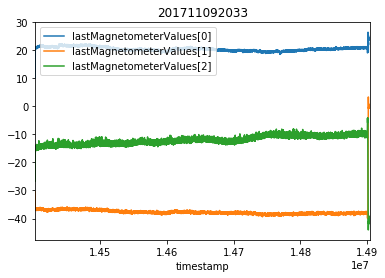

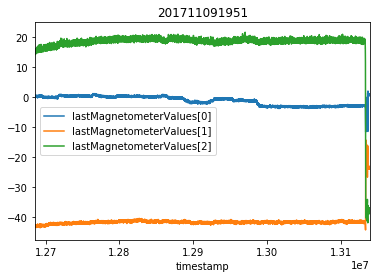

In [65]:
plotSensor(magData)

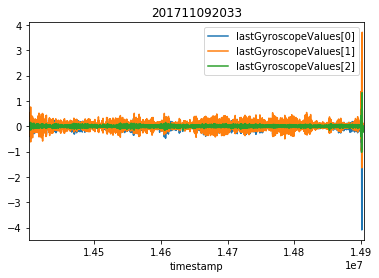

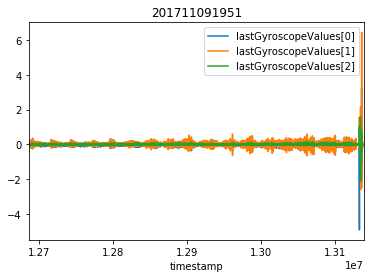

In [64]:
plotSensor(gyrData)

#### Tap Data

In [92]:
tapData.keys()

['201711091951', '201711092033']

In [750]:
mag.query('timestamp>=12687009 and timestamp<=12687076').plot()

In [749]:
gyr.query('timestamp>=12687009 and timestamp<=12687076').plot()

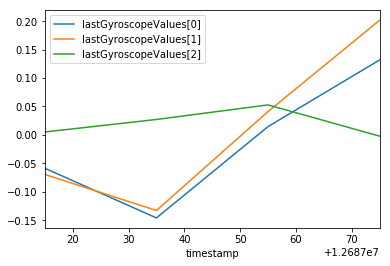

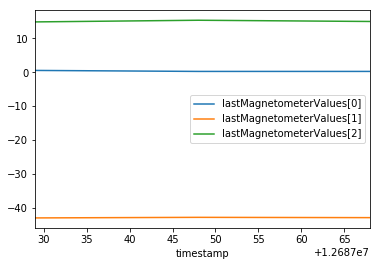

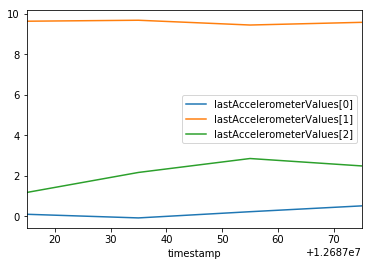

In [752]:
plt.show()

In [678]:
for idx, sample in toy.iterrows():
    for timestamp in data_Accelerometer.timestamp:
        if timestamp<sample.eventTime and timestamp>sample.downTime:
            print sample.eventTime, sample.downTime
            print data_Accelerometer.loc[data_Accelerometer['timestamp']==timestamp]
    break        

12687076.0 12687009.0
    timestamp  lastAccelerometerValues[0]  lastAccelerometerValues[1]  \
55   12687015                    0.107452                    9.624191   

    lastAccelerometerValues[2]  lastGyroscopeValues[0]  \
55                    1.183334               -0.004318   

    lastGyroscopeValues[1]  lastGyroscopeValues[2]  lastMagnetometerValues[0]  \
55                -0.01268               -0.005829                   0.323486   

    lastMagnetometerValues[1]  lastMagnetometerValues[2]  lastBtnId  
55                 -42.834473                  14.839172         -1  
12687076.0 12687009.0
    timestamp  lastAccelerometerValues[0]  lastAccelerometerValues[1]  \
56   12687035                   -0.072021                    9.672043   

    lastAccelerometerValues[2]  lastGyroscopeValues[0]  \
56                    2.169174                -0.05867   

    lastGyroscopeValues[1]  lastGyroscopeValues[2]  lastMagnetometerValues[0]  \
56               -0.069489                0.

In [91]:
for idx, tap in tapInfo.btnID.iteritems():
    btnID=idx
    print tap
    break

{u'12687536': {u'2': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=30.971323, y[0]=59.968765, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687535, downTime=12687476, deviceId=6, source=0x1002 }']}, u'12687010': [[u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=43.959297, y[0]=59.968765, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687009, downTime=12687009, deviceId=6, source=0x1002 }']], u'12688255': {u'5': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=19.981499, y[0]=48.97449, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688254, downTime=12688187, deviceId=6, source=0x1002 }']}, u'12687954': {u'4': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=24.976873, y[0]=48.9744

In [88]:
tapInfo.head()

,btnID
0,{u'12687536': {u'2': [u'MotionEvent { action=A...
1,{u'12691290': {u'5': [u'MotionEvent { action=A...
2,{u'12694955': {u'5': [u'MotionEvent { action=A...
3,{u'12696782': [[u'MotionEvent { action=ACTION_...
4,{u'12701418': {u'5': [u'MotionEvent { action=A...


                                                 btnID
0    {u'12687536': {u'2': [u'MotionEvent { action=A...
1    {u'12691290': {u'5': [u'MotionEvent { action=A...
2    {u'12694955': {u'5': [u'MotionEvent { action=A...
3    {u'12696782': [[u'MotionEvent { action=ACTION_...
4    {u'12701418': {u'5': [u'MotionEvent { action=A...
5    {u'12704484': {u'6': [u'MotionEvent { action=A...
6    {u'12707435': {u'6': [u'MotionEvent { action=A...
7    {u'12710888': {u'8': [u'MotionEvent { action=A...
8    {u'12713325': {u'6': [u'MotionEvent { action=A...
9    {u'12716518': {u'4': [u'MotionEvent { action=A...
10   {u'12719141': {u'3': [u'MotionEvent { action=A...
11   {u'12722181': {u'4': [u'MotionEvent { action=A...
12   {u'12725526': {u'6': [u'MotionEvent { action=A...
13   {u'12728240': {u'6': [u'MotionEvent { action=A...
14   {u'12730205': {u'3': [u'MotionEvent { action=A...
15   {u'12732318': [[u'MotionEvent { action=ACTION_...
16   {u'12735777': {u'3': [u'MotionEvent { action=A...
17   {u'12

In [352]:
x=str("{u'12687536': {u'2': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=30.971323, y[0]=59.968765, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687535, downTime=12687476, deviceId=6, source=0x1002 }']}, u'12687010': [[u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=43.959297, y[0]=59.968765, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687009, downTime=12687009, deviceId=6, source=0x1002 }']], u'12688255': {u'5': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=19.981499, y[0]=48.97449, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688254, downTime=12688187, deviceId=6, source=0x1002 }']}, u'12687954': {u'4': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=24.976873, y[0]=48.97449, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687953, downTime=12687953, deviceId=6, source=0x1002 }']}, u'12689176': {u'9': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=28.973173, y[0]=72.962, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12689174, downTime=12689174, deviceId=6, source=0x1002 }']}, u'12688012': {u'4': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=24.976873, y[0]=48.97449, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688011, downTime=12687953, deviceId=6, source=0x1002 }']}, u'12687076': [[u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=43.959297, y[0]=59.968765, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687076, downTime=12687009, deviceId=6, source=0x1002 }']], u'12688673': {u'7': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=19.981499, y[0]=66.96512, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688672, downTime=12688672, deviceId=6, source=0x1002 }']}, u'12689235': {u'9': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=28.973173, y[0]=72.962, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12689233, downTime=12689174, deviceId=6, source=0x1002 }']}, u'12688918': {u'8': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=15.985199, y[0]=65.965645, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688915, downTime=12688915, deviceId=6, source=0x1002 }']}, u'12688489': {u'6': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=17.983349, y[0]=51.97293, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688488, downTime=12688446, deviceId=6, source=0x1002 }']}, u'12687311': [[u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=53.950047, y[0]=38.9797, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687310, downTime=12687310, deviceId=6, source=0x1002 }']], u'12688188': {u'5': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=19.981499, y[0]=48.97449, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688187, downTime=12688187, deviceId=6, source=0x1002 }']}, u'12688448': {u'6': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=17.983349, y[0]=51.97293, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688446, downTime=12688446, deviceId=6, source=0x1002 }']}, u'12687327': [[u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=53.950047, y[0]=38.9797, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687326, downTime=12687310, deviceId=6, source=0x1002 }']], u'12688984': {u'8': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=15.985199, y[0]=65.965645, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688982, downTime=12688915, deviceId=6, source=0x1002 }']}, u'12687720': {u'3': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=28.973173, y[0]=61.967724, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687719, downTime=12687719, deviceId=6, source=0x1002 }']}, u'12687477': {u'2': [u'MotionEvent { action=ACTION_DOWN, actionButton=0, id[0]=0, x[0]=30.971323, y[0]=59.968765, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687476, downTime=12687476, deviceId=6, source=0x1002 }']}, u'12687787': {u'3': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=28.973173, y[0]=61.967724, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12687786, downTime=12687719, deviceId=6, source=0x1002 }']}, u'12688734': {u'7': [u'MotionEvent { action=ACTION_UP, actionButton=0, id[0]=0, x[0]=19.981499, y[0]=66.96512, toolType[0]=TOOL_TYPE_FINGER, buttonState=0, metaState=0, flags=0x0, edgeFlags=0x0, pointerCount=1, historySize=0, eventTime=12688731, downTime=12688672, deviceId=6, source=0x1002 }']}}").replace('\'','\'')

row=ast.literal_eval(str(ast.literal_eval(x)[str('12687010')][0][0].replace('MotionEvent ','').replace('=','\':\'').replace(', ','\', \'').replace('{ ','{\'').replace(' }','\'}')))

In [634]:
df=parse(tapInfo)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [635]:
toy=df[df['action']=='UP']

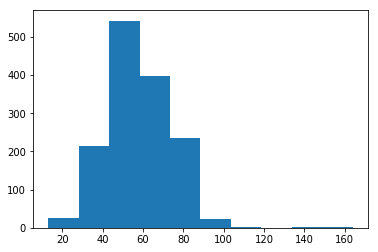

In [658]:
plt.hist(toy.eventTime-toy.downTime)
plt.show()

In [659]:
toy.eventTime-toy.downTime

1       67.0
3       16.0
5       59.0
7       67.0
9       58.0
11      67.0
13      42.0
15      59.0
17      67.0
19      59.0
21      80.0
23      84.0
25      75.0
27      93.0
29      84.0
32      68.0
34      83.0
36      66.0
38      93.0
40      92.0
42      44.0
44      49.0
46      40.0
48      65.0
50      67.0
52      73.0
54      75.0
56      67.0
58      74.0
60      67.0
        ... 
2859    65.0
2861    40.0
2863    25.0
2865    42.0
2867    49.0
2869    38.0
2871    41.0
2873    59.0
2875    25.0
2877    67.0
2879    55.0
2881    32.0
2883    50.0
2885    59.0
2887    49.0
2889    25.0
2891    41.0
2893    33.0
2895    41.0
2897    25.0
2899    47.0
2901    33.0
2903    25.0
2905    32.0
2907    41.0
2909    42.0
2911    34.0
2913    50.0
2915    42.0
2917    59.0
dtype: float64

In [612]:
toy

,action,actionButton,buttonState,downTime,eventTime,id0,x0,y0
0,UP,0.0,12687076.0,12687009.0,12687076.0,0.0,43.959297,59.968765
0,UP,0.0,12687327.0,12687310.0,12687326.0,0.0,53.950047,38.9797
0,UP,0.0,12687536.0,12687476.0,12687535.0,2.0,30.971323,59.968765
0,UP,0.0,12687787.0,12687719.0,12687786.0,3.0,28.973173,61.967724
0,UP,0.0,12688012.0,12687953.0,12688011.0,4.0,24.976873,48.97449
0,UP,0.0,12688255.0,12688187.0,12688254.0,5.0,19.981499,48.97449
0,UP,0.0,12688489.0,12688446.0,12688488.0,6.0,17.983349,51.97293
0,UP,0.0,12688734.0,12688672.0,12688731.0,7.0,19.981499,66.96512
0,UP,0.0,12688984.0,12688915.0,12688982.0,8.0,15.985199,65.965645
0,UP,0.0,12689235.0,12689174.0,12689233.0,9.0,28.973173,72.962


In [260]:
k=row.keys()

In [261]:
y.columns=k

In [295]:
y

,x[0],actionBtton,sorce,eventTime,pointerCont,historySize,flags,deviceId,downTime,action,y[0],bttonState,metaState,edgeFlags,id[0],toolType[0],eventTimestamp
0,43.959297,0,0x1002,12687009,1,0,0x0,6,12687009,ACTION_DOWN,59.968765,0,0,0x0,0,TOOL_TYPE_FINGER,12687536


0    12687536
Name: eventTimestamp, dtype: int64

In [287]:
pd.concat(pd.DataFrame('a',columns=['eventTimestamp']))

PandasError: DataFrame constructor not properly called!